## Toad的评分卡建立过程

In [1]:
import pandas as pd
import datetime
from sklearn.model_selection import train_test_split

from sklearn.metrics import roc_curve, confusion_matrix,auc
import sys 
sys.path.append("..")
from utils import  cate2num, get_threshold, get_RocCurve, get_KS
import gc
import toad
from toad.plot import bin_plot, badrate_plot

In [2]:
# load training data from oracle
raw_df = pd.read_csv("german.data-numeric", header=None, delimiter="\s+")

In [3]:
print("DF size: ", raw_df.shape)
raw_df.head()

DF size:  (1000, 25)


,0,1,2,3,4,5,6,7,8,9,...,15,16,17,18,19,20,21,22,23,24
0,1,6,4,12,5,5,3,4,1,67,...,0,0,1,0,0,1,0,0,1,1
1,2,48,2,60,1,3,2,2,1,22,...,0,0,1,0,0,1,0,0,1,2
2,4,12,4,21,1,4,3,3,1,49,...,0,0,1,0,0,1,0,1,0,1
3,1,42,2,79,1,4,3,4,2,45,...,0,0,0,0,0,0,0,0,1,1
4,1,24,3,49,1,3,3,4,4,53,...,1,0,1,0,0,0,0,0,1,2


In [4]:
renames = { i:"FEA_{}".format(i) for i in range(raw_df.shape[1]-1)}
renames[24] = "Y"
raw_df.rename(columns=renames,inplace=True)
raw_df["Y"] = raw_df["Y"].apply(lambda x: 0 if x == 1 else 1)

In [5]:
X, y = raw_df.drop(columns=['Y']), raw_df["Y"].astype("int")

X_train,  X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=2021, stratify=y)
print("Train/ test lenth,", X_train.shape, X_test.shape)

Train/ test lenth, (750, 24) (250, 24)


In [6]:
# droping cols first time 
train2, droplist = toad.selection.select(X_train, target=y_train,
                                         empty=0.6, iv = 0.02, corr = 0.7,
                                         return_drop=True)
print("Keep: ", train2.shape[1])
print("Drop empty: ", len(droplist["empty"]))
print("drop iv: ", len(droplist["iv"]))
print("drop corr: ",len(droplist["corr"]))

Keep:  15
Drop empty:  0
drop iv:  9
drop corr:  0


In [7]:
?combiner.fit

Object `combiner.fit` not found.


In [8]:
print("Staring trainning binning".center(60,"="))
combiner = toad.transform.Combiner()
combiner.fit(train2, y_train, method="chi", min_samples=0.05, empty_separate=True)

bins = combiner.export()

train3 = combiner.transform(train2)
test3  = combiner.transform(X_test[train3.columns])

=================Staring trainning binning==================


In [9]:
print("Staring WOE".center(60,"="))
trans = toad.transform.WOETransformer()

train_woe = trans.fit_transform(train3, y_train) #, exclude=useless_cols)
test_woe  = trans.transform(test3[train3.columns])

========================Staring WOE=========================


In [10]:
quality = toad.quality(train_woe, target=y_train)
quality

,iv,gini,entropy,unique
FEA_0,0.620594,0.371760,0.549659,4.0
FEA_1,0.311953,0.393785,0.579226,8.0
FEA_2,0.263143,0.396418,0.583572,4.0
FEA_3,0.216896,0.401209,0.588345,3.0
FEA_4,0.200139,0.404831,0.591154,4.0
FEA_9,0.152117,0.406824,0.595114,7.0
FEA_8,0.122510,0.409044,0.598013,4.0
FEA_20,0.056699,0.414834,0.604856,2.0
FEA_15,0.056065,0.414807,0.604895,2.0
FEA_16,0.049728,0.416250,0.605952,2.0


In [11]:
high_iv_cols = list(quality.loc[quality["iv"] >= 0.05,:].index)
print("Keeping {} cols".format(len(high_iv_cols)))

train_ivs = train_woe[high_iv_cols]
test_ivs = test_woe[high_iv_cols]

Keeping 9 cols


In [12]:
# droping cols 2nd time, cause the correlation will change due to binning and woe
train_ivs, droplist = toad.selection.select(train_ivs, target=y_train,
                                         empty=0.6, iv = 0.02, corr = 0.7,
                                         return_drop=True)
print("Keep: ", train_ivs.shape[1])
print("Drop empty: ", len(droplist["empty"]))
print("drop iv: ", len(droplist["iv"]))
print("drop corr: ",len(droplist["corr"]))

Keep:  9
Drop empty:  0
drop iv:  0
drop corr:  0


In [13]:
### Using l1+l2 to select features

from sklearn.linear_model import LogisticRegression

In [14]:
clf = LogisticRegression(penalty="elasticnet", 
                        C=0.1,
                        solver="saga", n_jobs=6,
                        l1_ratio=1)
clf.fit(train_ivs, y_train)

LogisticRegression(C=0.1, l1_ratio=1, n_jobs=6, penalty='elasticnet',
                   solver='saga')

In [15]:
coefs = clf.coef_.tolist()[0]
coefs

[0.7382315068662866,
 0.5796215057484497,
 0.515005199886822,
 0.47207517034683144,
 0.3561948083616271,
 0.34303942002518417,
 0.0,
 0.0,
 0.0]

In [16]:
### Using stepwise to select feas
train_woe_step = toad.selection.stepwise(train_ivs, y_train,
                                         # exclude=useless_cols,
                                         direction="both",
                                         criterion="aic",
                                         estimator="lr",
                                         intercept=True)
print("The # of feas in train_woe_step, {}".format(train_woe_step.shape[1]))

The # of feas in train_woe_step, 8


In [17]:
## Save configs for lr_utils.LR_preprocessing

final_cols = list(train_woe_step.columns)
final_bins = {}
for k,v in bins.items():
    if k in final_cols:
        final_bins[k] = v

final_woes ={}
woes = trans.rules
for k,v in woes.items():
    if k in final_cols:
        final_woes[k] = v

configs = {
    "keep_cols": list(train_woe_step.columns) ,
    "bins":  final_bins,
    "woes": woes
}
with open("lr_config_no_zero", "w", encoding="utf-8") as f:
    f.write(str(configs))

In [18]:
configs

{'keep_cols': ['FEA_0',
  'FEA_1',
  'FEA_2',
  'FEA_3',
  'FEA_4',
  'FEA_9',
  'FEA_8',
  'FEA_15'],
 'bins': {'FEA_0': [2, 3, 4],
  'FEA_1': [9, 12, 13, 18, 20, 36, 45],
  'FEA_2': [2, 3, 4],
  'FEA_3': [14, 39],
  'FEA_4': [2, 3, 5],
  'FEA_8': [2, 3, 4],
  'FEA_9': [26, 28, 35, 39, 49, 54],
  'FEA_15': [1]},
 'woes': {'FEA_0': {'value': array([0, 1, 2, 3], dtype=int64),
   'woe': array([ 0.74193734,  0.4504165 , -0.25131443, -1.14133723])},
  'FEA_1': {'value': array([0, 1, 2, 3, 4, 5, 6, 7], dtype=int64),
   'woe': array([-1.08422355, -0.47957308, -0.04771547, -0.90190199,  0.2382338 ,
          -0.03800933,  0.61245827,  1.09415794])},
  'FEA_2': {'value': array([0, 1, 2, 3], dtype=int64),
   'woe': array([ 1.21502264,  0.05742105,  0.12945807, -0.67990195])},
  'FEA_3': {'value': array([0, 1, 2], dtype=int64),
   'woe': array([ 0.24550046, -0.51196783,  0.54252135])},
  'FEA_4': {'value': array([0, 1, 2, 3], dtype=int64),
   'woe': array([ 0.26892619,  0.0588405 , -1.08422355, 

### Fit Model

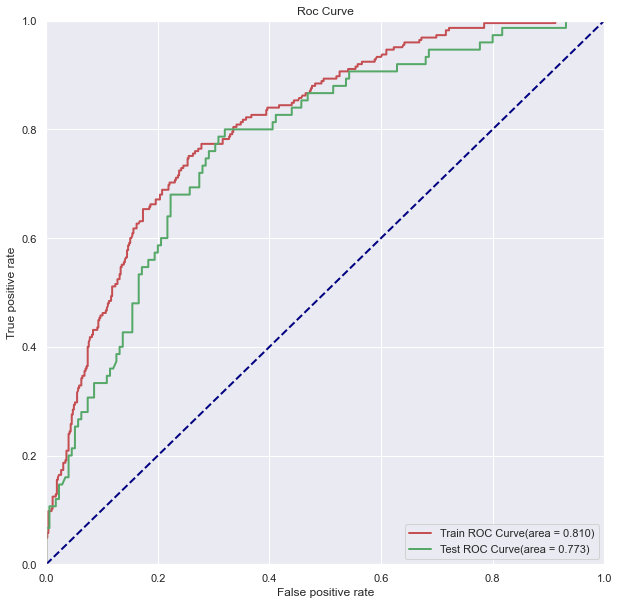

KS train/test 0.491, 0.470


In [19]:
test_woe_step = test_ivs[train_woe_step.columns]
clf = LogisticRegression(penalty="elasticnet", 
                        C=0.1,
                        solver="saga", n_jobs=6,
                        l1_ratio=0.3)

clf.fit(train_woe_step, y_train)

y_train_pred = clf.predict_proba(train_woe_step)[:,1]
y_test_pred = clf.predict_proba(test_woe_step)[:,1]

tt = get_RocCurve(y_train, y_train_pred,
                 with_test=True,
                 y_test_true=y_test,
                 y_test_prob=y_test_pred)
thred = get_threshold(y_train, y_train_pred)
train_ks = get_KS(y_train, y_train_pred, thred)
test_ks = get_KS(y_test, y_test_pred, thred)
print("KS train/test {:.3f}, {:.3f}".format(train_ks, test_ks))

In [20]:
import pickle
with open( "lr_model_no_zero","wb") as f:
    pickle.dump(clf, f)

In [21]:
# psi from toad.metrics
psi = toad.metrics.PSI(y_test_pred, y_train_pred)
psi

0.09530062106392603

In [22]:
from utils import PSI
# psi from utils
psi_, detail, bins = PSI(y_train_pred, y_test_pred,length=10, return_bins=True, equal="freq")

In [23]:
psi_

0.04090257311619848